## Image Preprocessing and Augmentation

This section defines the preprocessing steps applied to input images before training the deep learning model. The transformations are as follows:
- **Resizing**: All images are resized to 224x224 pixels.
- **Augmentation**:
  - Random horizontal flipping to add variability.
  - Random rotation to simulate different orientations.
  - Random resized cropping to focus on different parts of the image.
  - Color jittering to simulate brightness and contrast variations.
- **Normalization**: Pixel values are normalized using the mean and standard deviation of the ImageNet dataset.

Additionally, the function `display_image_before_after` is defined to visualize an input image before and after applying these transformations. This helps in understanding how the preprocessing pipeline alters the image data.


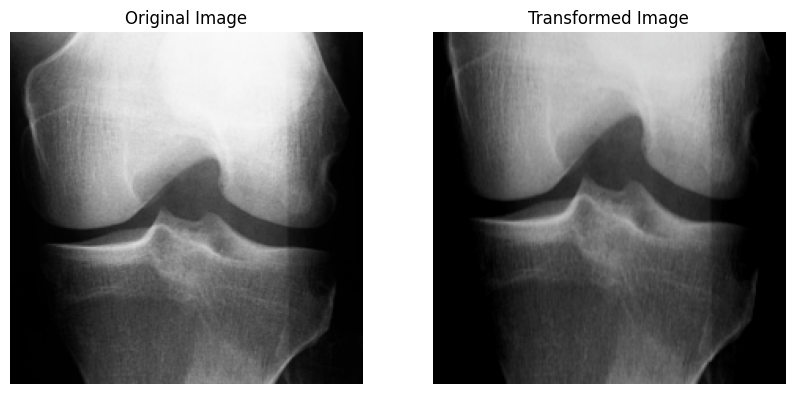

In [20]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),     
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Function to display an image before and after transformation
def display_image_before_after(image_path):
    original_image = Image.open(image_path).convert('RGB')
    transformed_image = transform(original_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image")

    transformed_image_np = transformed_image.permute(1, 2, 0).numpy()  
    transformed_image_np = transformed_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406] 
    transformed_image_np = transformed_image_np.clip(0, 1) 

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image_np)
    plt.axis('off')
    plt.title("Transformed Image")

    plt.show()

# Example usage
image_path = "C:/Users/ibrah/OneDrive/Desktop/Datasets/knee/train/0/9005075L.png"  # Replace with your image path
display_image_before_after(image_path)


## Model Training and Evaluation

This section demonstrates the complete pipeline for training, validating, and testing the deep learning model for osteoarthritis classification. 

### Key Steps:
- **Data Preparation**:
  - Load datasets for training, validation, and testing.
  - Apply data augmentation techniques (e.g., resizing, random rotations, cropping, and color jittering).
  - Normalize images based on ImageNet statistics.

- **Model Architecture**:
  - Use the pre-trained `EfficientNet-B0` model.
  - Replace the classification layer with a custom layer for classifying 6 severity levels (0–5).

- **Training Process**:
  - Utilize `CrossEntropyLoss` as the loss function and the `Adam` optimizer.
  - Adjust the learning rate dynamically using a cosine annealing scheduler.
  - Fine-tune the last 30 layers of the pre-trained network.

- **Validation and Early Stopping**:
  - Monitor validation loss to decide model improvements.
  - Stop training early if validation performance stagnates to avoid overfitting.

- **Evaluation**:
  - Save the best model during training.
  - Evaluate the model on the test set for final performance metrics.

The training and validation performance is displayed after each epoch, and the test set accuracy and loss are reported after evaluation.


In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

data_path = "C:\\Users\\ibrah\\OneDrive\\Desktop\\Datasets\\knee" #Replace with your own path
train_path = f"{data_path}\\train"
val_path = f"{data_path}\\val"
test_path = f"{data_path}\\test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),     
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")


model.classifier = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(model.classifier[1].in_features, 6)  # 6 output classes for levels 0-5, if you have 0-4 then it will be 5.
)


model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)  
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  

# Fine-tune more layers
for param in model.features[-30:].parameters(): 
    param.requires_grad = True

num_epochs = 25
early_stopping_patience = 5
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = correct / len(train_dataset) * 100

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_dataset)
    val_accuracy = val_correct / len(val_dataset) * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth") 
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss, test_correct = 0.0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_loss /= len(test_dataset)
test_accuracy = test_correct / len(test_dataset) * 100
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/25] Train Loss: 1.4002, Train Accuracy: 42.40% | Val Loss: 1.1434, Val Accuracy: 50.61%
Epoch [2/25] Train Loss: 1.0511, Train Accuracy: 56.30% | Val Loss: 0.9643, Val Accuracy: 60.05%
Epoch [3/25] Train Loss: 0.9224, Train Accuracy: 61.96% | Val Loss: 0.9102, Val Accuracy: 62.35%
Epoch [4/25] Train Loss: 0.8588, Train Accuracy: 63.91% | Val Loss: 0.8701, Val Accuracy: 64.65%
Epoch [5/25] Train Loss: 0.8211, Train Accuracy: 65.47% | Val Loss: 0.8468, Val Accuracy: 65.25%
Epoch [6/25] Train Loss: 0.7966, Train Accuracy: 66.72% | Val Loss: 0.8342, Val Accuracy: 64.77%
Epoch [7/25] Train Loss: 0.7572, Train Accuracy: 67.81% | Val Loss: 0.8626, Val Accuracy: 64.41%
Epoch [8/25] Train Loss: 0.7558, Train Accuracy: 67.71% | Val Loss: 0.8337, Val Accuracy: 64.16%
Epoch [9/25] Train Loss: 0.7411, Train Accuracy: 68.48% | Val Loss: 0.8585, Val Accuracy: 64.29%
Epoch [10/25] Train Loss: 0.7252, Train Accuracy: 68.90% | Val Loss: 0.8210, Val Accuracy: 65.74%
Epoch [11/25] Train Loss: 0.7

## Visualizing Training and Validation Metrics

This section visualizes the training and validation metrics recorded during the model training process. The metrics include:

- **Loss**:
  - Tracks the model's ability to minimize the error during training and validation.
  - A gradual decrease in both training and validation loss indicates proper learning, while a divergence might indicate overfitting.

- **Accuracy**:
  - Measures the percentage of correctly classified samples in training and validation datasets.
  - Helps monitor model performance and ensure improvement over epochs.

### Insights:
- **Loss Plot**:
  - Compare training and validation loss to check for overfitting.
  - Ideally, both should decrease and converge over time.
- **Accuracy Plot**:
  - Observe the difference in training and validation accuracy to evaluate the model's generalization.
  - A significant gap may suggest overfitting or the need for better regularization.

The results from these visualizations can guide further tuning of the model or training process.


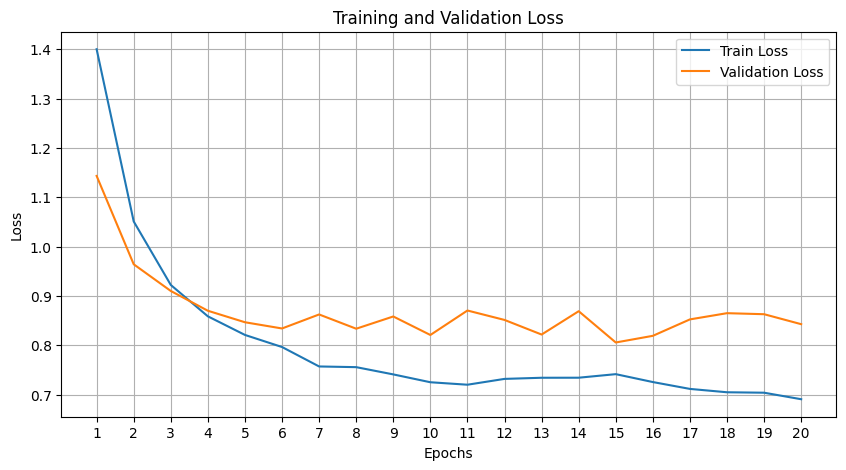

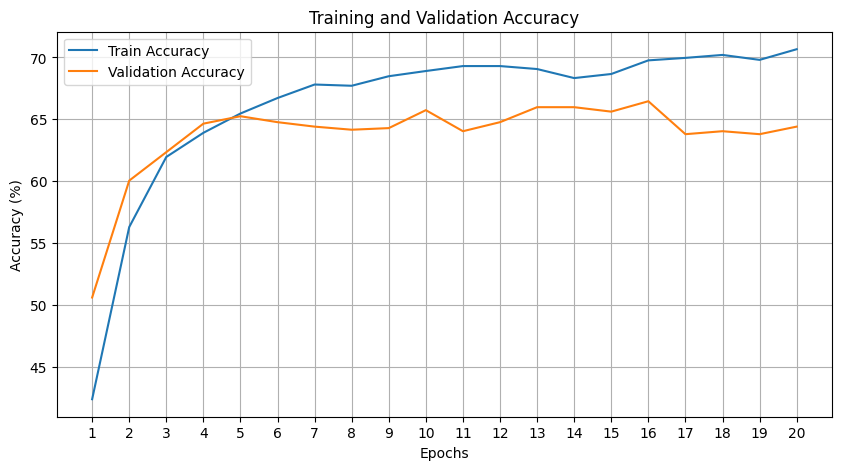

Test Loss: 0.7529
Test Accuracy: 67.03%


In [3]:
import matplotlib.pyplot as plt

# Metrics from training and validation
train_losses = [1.4002, 1.0511, 0.9224, 0.8588, 0.8211, 0.7966, 0.7572, 0.7558, 0.7411, 0.7252, 0.7202, 0.7320, 0.7343, 0.7344, 0.7416, 0.7256, 0.7117, 0.7049, 0.7040, 0.6908]
val_losses = [1.1434, 0.9643, 0.9102, 0.8701, 0.8468, 0.8342, 0.8626, 0.8337, 0.8585, 0.8210, 0.8706, 0.8515, 0.8219, 0.8692, 0.8058, 0.8193, 0.8526, 0.8652, 0.8631, 0.8429]
train_accuracies = [42.40, 56.30, 61.96, 63.91, 65.47, 66.72, 67.81, 67.71, 68.48, 68.90, 69.30, 69.30, 69.06, 68.33, 68.66, 69.76, 69.96, 70.20, 69.80, 70.66]
val_accuracies = [50.61, 60.05, 62.35, 64.65, 65.25, 64.77, 64.41, 64.16, 64.29, 65.74, 64.04, 64.77, 65.98, 65.98, 65.62, 66.46, 63.80, 64.04, 63.80, 64.41]

epochs = list(range(1, len(train_losses) + 1))

# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()




## Single Image Classification

This section demonstrates how to use the trained model to classify a single X-ray image into one of the osteoarthritis severity leve.).

### Key Steps:
1. **Model Initialization**:
   - Load the trained weights (`best_model.pth`) into the `EfficientNet-B0` model.
   - Modify the classifier to output predictis for 6 severity levels.

2. **Image Preprocessing**:
   - Resize the input image to 224x224 pixels.
   - Normalize the pixel values using the ImageNet dataset's mean and standard deviation.
   - Convert the image into a tensor format with an additional batch dimension.

3. **Prediction**:
   - Pass the preprocessed image through the model.
   - Predict the severity level by selecting the class with the highest probability.

4. **Visualization**:
   - Display the input image along with its predicted severity level.

This approach provides an easy and interpretable way to classify a single X-ray image using the trained model.
g the trained model.


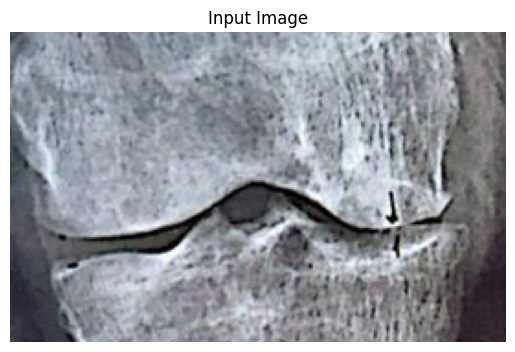

Predicted Class: 3


3

In [6]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Reinitialize the model architecture
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

# Modify the classifier to match the training configuration
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 6)  # 6 classes for levels 0-5, 0-4 as per requirement.
)

# Load the trained weights
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classification function
def classify_image(image_path):
    # Load and display the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Transform the image and prepare for classification
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict class
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = output.argmax(1).item()

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example usage
# Provide the path to an image
image_path = "C:/Users/ibrah/OneDrive/Desktop/100.png"
classify_image(image_path)


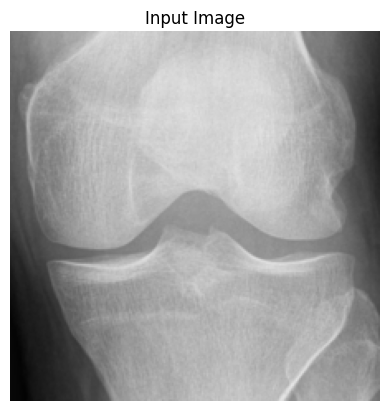

Predicted Class: 0


0

In [16]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Reinitialize the model architecture
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

# Modify the classifier to match the training configuration
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 6)  # 6 classes for levels 0-5, as per requirement.
)

# Load the trained weights
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classification function
def classify_image(image_path):
    # Load and display the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Transform the image and prepare for classification
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict class
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = output.argmax(1).item()

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example usage
# Provide the path to an image
image_path = "C:/Users/ibrah/OneDrive/Desktop/Datasets/knee/test/0/9197994L.png"
classify_image(image_path)


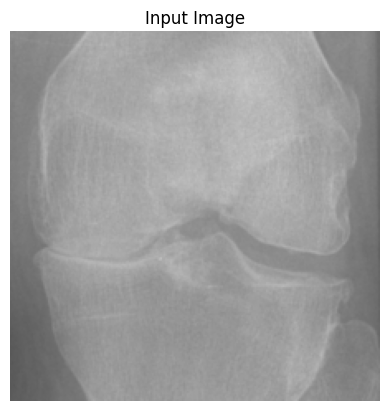

Predicted Class: 4


4

In [17]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Reinitialize the model architecture
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

# Modify the classifier to match the training configuration
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[1].in_features, 6)  # 6 classes for levels 0-5, as per requirement.
)

# Load the trained weights
model_path = "best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classification function
def classify_image(image_path):
    # Load and display the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Transform the image and prepare for classification
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict class
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = output.argmax(1).item()

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example usage
# Provide the path to an image
image_path = "C:/Users/ibrah/OneDrive/Desktop/Datasets/knee/test/4/9992318L.png"
classify_image(image_path)
